In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

sns.set_context("paper", font_scale=1.2)
sns.set_style("white")

# Load data
df = pd.read_csv("../data/merged_with_property.csv", low_memory=False)
df_sub = df[df['city'].isin(['Copenhagen', 'Oslo'])].copy()

# Select features
drop_features = ['price_local', 'latitude', 'longitude', 'id']
features = df_sub.select_dtypes(include=[np.number]).columns.tolist()
features = [f for f in features if f not in drop_features]

X = df_sub[features].apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.median()).dropna(axis=1, how='all')
y = (df_sub['city'] == 'Oslo').astype(int)

print(f"Dataset: {len(X)} samples, {X.shape[1]} features")
print(f"Class balance: Copenhagen={sum(y==0)}, Oslo={sum(y==1)}")

Dataset: 34842 samples, 34 features
Class balance: Copenhagen=22684, Oslo=12158


In [8]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
clf = LogisticRegressionCV(
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='neg_log_loss',
    random_state=42,
    max_iter=1000
)
clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
logloss = log_loss(y_test, y_pred_proba)

print("="*60)
print("Test Set Evaluation")
print("="*60)
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Log Loss: {logloss:.4f}")
print("="*60)

Train set: 27873 samples
Test set: 6969 samples
Test Set Evaluation
Accuracy: 0.7439
ROC-AUC: 0.7611
Log Loss: 0.5414


In [9]:
# Extract coefficients
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coef': clf.coef_[0]
})

coef_df = coef_df[coef_df['coef'] != 0].copy()
coef_df['abs_coef'] = coef_df['coef'].abs()
coef_df['odds_ratio'] = np.exp(coef_df['coef'])
coef_df = coef_df.sort_values('abs_coef', ascending=False)

print("="*60)
print("Top 10 Features")
print("="*60)
print(coef_df.head(10).to_string(index=False))
print("="*60)

# Interpret top feature
if len(coef_df) > 0:
    top = coef_df.iloc[0]
    print("")
    print(f"Top feature: {top['feature']}")
    print(f"Coefficient: {top['coef']:.4f}")
    print(f"Odds ratio: {top['odds_ratio']:.4f}")
    print("")
    if top['coef'] > 0:
        print(f"Interpretation: 1 SD increase in {top['feature']} multiplies")
        print(f"the odds of Oslo (vs Copenhagen) by {top['odds_ratio']:.2f}")
    else:
        print(f"Interpretation: 1 SD increase in {top['feature']} multiplies")
        print(f"the odds of Oslo (vs Copenhagen) by {top['odds_ratio']:.2f}")
        print("(decreases odds since OR < 1)")

Top 10 Features
                  feature      coef  abs_coef  odds_ratio
          availability_60  1.665150  1.665150    5.286466
          availability_30 -1.613700  1.613700    0.199149
        reviews_per_month  0.914701  0.914701    2.496029
   number_of_reviews_l30d -0.582209  0.582209    0.558663
          availability_90  0.516501  0.516501    1.676152
      review_scores_value  0.477461  0.477461    1.611977
host_total_listings_count -0.339229  0.339229    0.712319
estimated_occupancy_l365d  0.263952  0.263952    1.302065
     number_of_reviews_ly -0.263337  0.263337    0.768483
   minimum_nights_avg_ntm -0.249867  0.249867    0.778904

Top feature: availability_60
Coefficient: 1.6651
Odds ratio: 5.2865

Interpretation: 1 SD increase in availability_60 multiplies
the odds of Oslo (vs Copenhagen) by 5.29


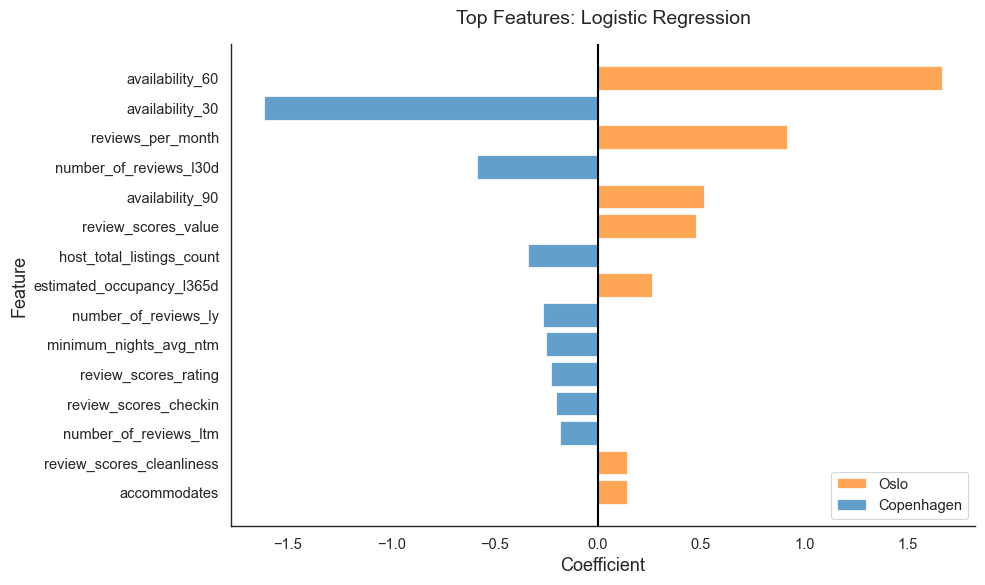

In [10]:
# Plot top features
top_n = min(15, len(coef_df))
plot_df = coef_df.head(top_n).copy()

plt.figure(figsize=(10, 6))
colors = ['#ff7f0e' if c > 0 else '#1f77b4' for c in plot_df['coef']]
plt.barh(range(len(plot_df)), plot_df['coef'], color=colors, alpha=0.7)
plt.yticks(range(len(plot_df)), plot_df['feature'])
plt.axvline(0, color='black', linewidth=1.5, linestyle='-')
plt.xlabel('Coefficient', fontsize=13)
plt.ylabel('Feature', fontsize=13)
plt.title('Top Features: Logistic Regression', fontsize=14, pad=15)
plt.gca().invert_yaxis()

from matplotlib.patches import Patch
legend = [
    Patch(facecolor='#ff7f0e', alpha=0.7, label='Oslo'),
    Patch(facecolor='#1f77b4', alpha=0.7, label='Copenhagen')
]
plt.legend(handles=legend, loc='lower right')

sns.despine()
plt.tight_layout()
plt.savefig('logreg_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()